# Simulación

In [5]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf, keras

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [6]:
model = keras.models.load_model('lstm_model')

In [16]:
csv_path = "test_datasets/ipf_totals_test.csv"
df = pd.read_csv(csv_path)
display(df)
date_time = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')

timestamp  invocations
0      2019-07-29 00:00:00        22312
1      2019-07-29 00:01:00        10803
2      2019-07-29 00:02:00        11379
3      2019-07-29 00:03:00        11767
4      2019-07-29 00:04:00        12153
...                    ...          ...
20155  2019-08-11 23:55:00        14385
20156  2019-08-11 23:56:00        11883
20157  2019-08-11 23:57:00        11105
20158  2019-08-11 23:58:00        11089
20159  2019-08-11 23:59:00        11928

[20160 rows x 2 columns]

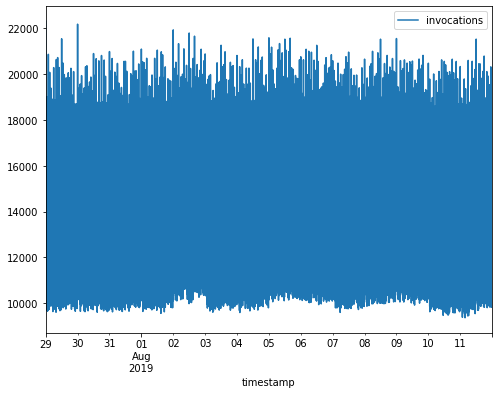

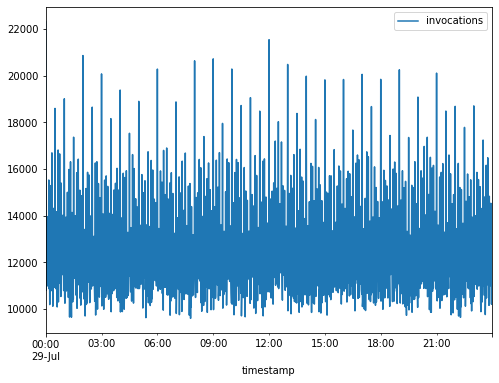

In [17]:
plot_cols = ['invocations']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:1440]
plot_features.index = date_time[:1440]
_ = plot_features.plot(subplots=True)

In [18]:
df.describe().transpose()

count         mean         std     min      25%      50%  \
invocations  20160.0  12291.46002  2048.93547  9360.0  11008.0  11652.5   

                 75%      max  
invocations  12606.0  22312.0

In [19]:
df = df.filter(items=['invocations'])
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
num_features = df.shape[1]

In [21]:
df = (df - df.mean()) / df.std()

In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, df=df,
               label_columns=None):
    # Store the raw data.
    self.df = df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [30]:
w2 = WindowGenerator(input_width=1440, label_width=1, shift=1440,
                     label_columns=['invocations'])
w2

Total window size: 2880
Input indices: [   0    1    2 ... 1437 1438 1439]
Label indices: [2879]
Label column name(s): ['invocations']

In [32]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(df[:w2.total_window_size]),
                           np.array(df[100:100+w2.total_window_size]),
                           np.array(df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [34]:
w2.example = example_inputs, example_labels

In [97]:
def plot(self, model=None, plot_col='invocations', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    #plt.scatter(self.label_indices, labels[n, :, label_col_index],
    #            edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [m]')

WindowGenerator.plot = plot

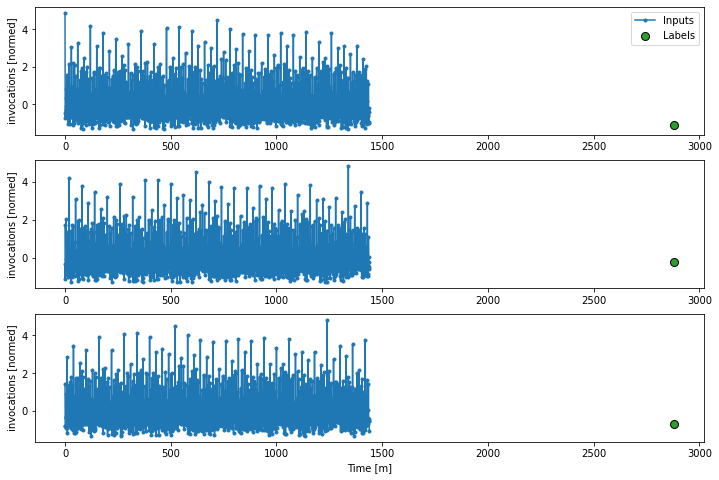

In [36]:
w2.plot()


In [37]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [59]:
@property
def test(self):
  return self.make_dataset(self.df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.test = test
WindowGenerator.example = example

In [60]:
# Each element is an (inputs, label) pair.
w2.test.element_spec

(TensorSpec(shape=(None, 1440, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [61]:
for example_inputs, example_labels in w2.test.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1440, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [68]:
wide_window = WindowGenerator(
    input_width=1440, label_width=1440, shift=1,
    label_columns=['invocations'])

wide_window

Total window size: 1441
Input indices: [   0    1    2 ... 1437 1438 1439]
Label indices: [   1    2    3 ... 1438 1439 1440]
Label column name(s): ['invocations']

In [71]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model(wide_window.example[0]).shape)

Input shape: (32, 1440, 1)
Output shape: (32, 1440, 1)


In [91]:
model.evaluate(wide_window.test, verbose=0)

[0.16923370957374573, 0.32301515340805054]

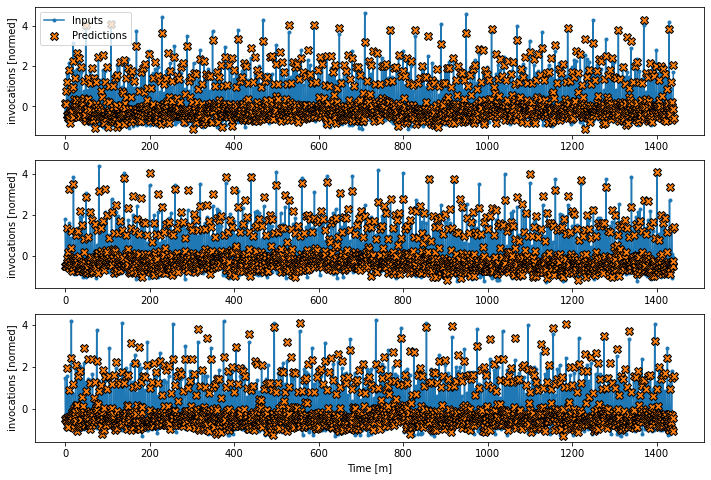

In [98]:
wide_window.plot(model)

In [101]:
prediction = model.predict(single_step_window.test)
# show the inputs and predicted outputs
for i in range(len(single_step_window.test)):
	print("X=%s, Predicted=%s" % (list(single_step_window.test)[i], prediction[i]))

X=(<tf.Tensor: shape=(32, 1, 1), dtype=float32, numpy=
array([[[-0.63323617]],

       [[ 0.25551805]],

       [[ 1.5361831 ]],

       [[-0.3281997 ]],

       [[-0.02413937]],

       [[-0.5883348 ]],

       [[ 1.802663  ]],

       [[ 0.06517529]],

       [[-0.07782579]],

       [[-0.6669122 ]],

       [[ 0.6205857 ]],

       [[-0.8235789 ]],

       [[-0.47900972]],

       [[-0.67960167]],

       [[ 4.1609607 ]],

       [[-0.6059049 ]],

       [[-0.59663177]],

       [[-0.39848012]],

       [[-0.79234314]],

       [[-0.54050505]],

       [[ 1.6591737 ]],

       [[-0.08563472]],

       [[-0.43752477]],

       [[-0.45851126]],

       [[-0.35162652]],

       [[ 0.65474975]],

       [[-0.757203  ]],

       [[ 0.7899419 ]],

       [[-0.45314264]],

       [[-0.23058805]],

       [[-0.21985076]],

       [[-0.36529213]]], dtype=float32)>, <tf.Tensor: shape=(32, 1, 1), dtype=float32, numpy=
array([[[ 1.2819047 ]],

       [[-0.46095157]],

       [[-0.52683944]],

 